
The goal of this project is to select 3 Market Factors & ETFs that track those factors to the best of their ability and to create a portfolio base on an investor profile that I create.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import psycopg2 
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
from scipy import stats
from scipy.stats import chi2
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
import os
%matplotlib inline

In [2]:
factor_d = pd.DataFrame()
try:
    url = 'Factorsdaily.xlsx'
    factor_d=pd.read_excel(url,skiprows = 4,na_values = -99)
except FileNotFoundError:
    url = 'https://www.dropbox.com/s/qam7kkx1pbp7tyt/Factorsdaily.xlsx?dl=1'
    factor_d=pd.read_excel(url,skiprows = 4,na_values = -99)

factor_d = factor_d.set_index('Unnamed: 0').iloc[:-2,:]
factor_d.index.names = ['Date']
factor_d.index = pd.to_datetime(factor_d.index, format = '%Y%m%d')
factor_d = factor_d.rename(columns = {'Mkt-RF':'MKTRF'})/100
factor_d.tail()

,MKTRF,SMB,HML,RMW,CMA,MOM,RF
Date,,,,,,,
2019-08-26,0.0108,-0.0002,-0.0021,0.0017,-0.0013,0.0045,0.00007
2019-08-27,-0.0046,-0.0087,-0.0068,0.0026,0.0010,0.0092,0.00007
2019-08-28,0.0068,0.0047,0.0062,0.0042,0.0020,-0.0092,0.00007
2019-08-29,0.0135,0.0031,0.0034,0.0019,-0.0013,-0.0094,0.00007
2019-08-30,0.0003,-0.0038,0.0026,0.0010,0.0011,-0.0025,0.00007


Based on the factors we have available above we select to investigate the Market factor (MKTRF), the Small Minus Big factor (SMB) and the Momentum (MOM) factor. Our choice was based on a modified Fama and French 3 factor model where we supplement HML with Momentum, because of the recent popularity of the latter.

In [3]:
def mergePTF(path,factor_d,min_days = 1):
    path = path
    fileList = []
    nameList = []
    for r, d, f in os.walk(path):
        for file in f:
            if '.csv' in file:
                fileList.append(os.path.join(r, file))
        nameList.append(f)
    nameList = nameList[0]
    i = 0
    while i < len(nameList):
        nameList[i] = nameList[i][:-4]
        i = i + 1
    
    factor_d_dummy = factor_d.copy()
    factor_d_dummy['DUMMY'] = 0
    iniDF = factor_d_dummy[['DUMMY']]

    j = 0
    for i in fileList:
        try:
            newDF = pd.read_csv(i, parse_dates = ['Date']).set_index('Date')[['Adj Close']].rename(columns={'Adj Close':str(nameList[j])})
        except ValueError:
            newDF = pd.read_csv(i, parse_dates = ['date']).set_index('date')[['adjclose']].rename(columns={'adjclose':str(nameList[j])})
        newDF.index.names = ['Date']

        if (newDF.shape[0] >= min_days):
            iniDF = pd.merge(iniDF,newDF,left_index=True,right_index=True)

        j = j + 1
    iniDF = ((iniDF/iniDF.shift(1))-1).drop(columns = 'DUMMY')

    return iniDF.subtract(factor_d['RF'],axis = 'index').dropna()

In [4]:
def Time_Series_Regressions_chosenFactor(portfolios, factors, chosenFactor,ptf_list):
    #chosenFactor is a list of factors 
    df = pd.merge(portfolios, factors, left_index = True, right_index = True)

    E = pd.DataFrame(df[ptf_list].mean()*252, columns = ['AvgReturns'])
    E['Std'] = df[ptf_list].std()*252**.5
    E['alpha'] = E['AvgReturns']*np.nan
    E['t_alpha'] = E['AvgReturns']*np.nan
    #E['tracking_error'] = E['AvgReturns']*np.nan 
    E['tracking_error'] = E['AvgReturns']*np.nan
    E['b_distance_to_1'] = E['AvgReturns']*np.nan
    E['b/te'] = E['AvgReturns']*np.nan
    
    for f in chosenFactor:
        bName = 'b_' + f
        tName = 't_' + f
        E[bName] = E['AvgReturns']*np.nan
        E[tName] = E['AvgReturns']*np.nan
        
    T = df.shape[0]
    muF = df[chosenFactor].mean()
    invCovF = np.linalg.inv(df[chosenFactor].cov())
    Resid = pd.DataFrame([], index = df.index, columns = ptf_list)
    x = sm.add_constant(df[chosenFactor])
    
    for ptf in ptf_list:
        y = df[ptf]
        res = sm.OLS(y,x).fit()
        
        E.loc[ptf,'alpha'] = res.params[0]*252
        
        E.loc[ptf,'t_alpha'] = res.tvalues[0]

        #E.loc[ptf,'tracking_error'] = res.bse[0]*252**0.5
        
        if len(chosenFactor)==1:
            E.loc[ptf,'tracking_error'] = ((np.subtract(np.array(df[ptf]),np.array(df[chosenFactor[0]]))**2).sum()/(portfolios.shape[0]-1))**0.5
        

        i = 1
        for f in chosenFactor:
            E.loc[ptf,'b_'+f] = res.params[i]  
            
            if len(chosenFactor)==1:
                E.loc[ptf,'b_distance_to_1'] = abs(E.loc[ptf,'b_'+f]-1)
                E.loc[ptf,'b/te'] = E.loc[ptf,'b_'+f]/E.loc[ptf,'tracking_error']
            E.loc[ptf,'t_'+f] = res.tvalues[i]
            i = i + 1
        
        E.loc[ptf,'R-Squared'] = res.rsquared
        Resid.loc[:,ptf] = res.resid # this is for GRS

    E['SR'] = E['AvgReturns']/E['Std']
    E['AR'] = 252**.5*E['t_alpha']/T**.5  
    E['IR'] = E['alpha']/E['tracking_error']
    
    # GRS test
    invCov = np.linalg.inv(Resid.cov())
    chi = T*(1+(muF.values @ invCovF @ muF.values.T))**(-1)*(E.alpha.values @invCov@ E.alpha.values.T)
    N = Resid.shape[1]   
    
    return [E, [chi,(1-chi2.cdf(chi,N))*100]]

After choosing the factors we wanted to investigate we looked for ETFs that track those factors. We collected data for 10 ETFs for every factor. We believe this number will give us sufficient data to select the best tracking one. 
Looking on the time series of the different ETFs we observed that some factors have been tracked for much longer periods than others.

In order for our analysis to have meaningful results, we decided to run all the factors and ETFs based on the time period that the shortest exhibits. So we shortened the time frame and observations of our analysis to 744 observations or 09/16/2016. We also expect that the most recent data will provide better representation of the efficiency of the ETFs to track those factors in the short-term futute.

In [5]:
allPTF = mergePTF("DATA/",factor_d)
allPTF

,DIA_MKTRF,DWAS_MOM,DWTR_MOM,FDMO_MOM,IJH_SMB,IJR_SMB,IVV_MKTRF,IWM_MKTRF,IWO_SMB,MTUM_MOM,...,SPSM_SMB,SPY_MKTRF,VB_SMB,VIOO_SMB,VONE_MKTRF,VOO_MKTRF,VTI_MKTRF,XMMO_MOM,XSMO_MOM,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,
2016-09-16,-0.005156,-0.002925,-0.000829,-0.005173,-0.004915,-0.001814,-0.004167,-0.001485,-0.003750,-0.001317,...,-0.001678,-0.003876,-0.003827,-0.000824,-0.005166,-0.003925,-0.004008,0.011255,-0.001645,-0.003782
2016-09-19,0.000045,0.007697,0.008101,0.004581,0.007482,0.006480,0.000500,0.006637,0.007703,0.001430,...,0.009042,0.000177,0.006488,0.006510,0.001819,0.000296,0.001450,0.001900,0.008957,-0.000029
2016-09-20,0.000377,-0.001592,-0.000416,-0.000606,-0.004641,-0.003928,0.000083,-0.004249,-0.002787,0.001036,...,-0.002770,0.000037,-0.003736,-0.003429,0.000275,0.000092,-0.000465,-0.000645,-0.006579,0.000289
2016-09-21,0.008883,0.015310,0.020722,0.012395,0.013162,0.015395,0.011160,0.014480,0.013167,0.014091,...,0.012030,0.011236,0.013930,0.013441,0.009979,0.011216,0.011474,0.000944,0.012048,0.010907
2016-09-22,0.005465,0.011176,0.008751,0.007374,0.011955,0.014354,0.006132,0.014354,0.013868,0.007586,...,0.012570,0.006291,0.013244,0.016380,0.006550,0.005995,0.007289,0.018726,0.013441,0.006490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-26,0.010894,0.013639,0.001258,0.009726,0.008365,0.009272,0.011066,0.010932,0.011320,0.012851,...,0.011068,0.010988,0.008666,0.010992,0.010324,0.011017,0.010046,0.007080,0.012069,0.010913
2019-08-27,-0.005087,-0.012842,0.004217,0.002412,-0.011618,-0.012679,-0.003902,-0.014897,-0.014342,0.000769,...,-0.013839,-0.003994,-0.011129,-0.013581,-0.003020,-0.004002,-0.004703,-0.005092,-0.008865,-0.003273
2019-08-28,0.009977,0.011346,-0.000531,0.003032,0.009757,0.011885,0.006688,0.011597,0.010618,0.004542,...,0.011099,0.006972,0.009159,0.012509,0.005241,0.006877,0.007048,0.004629,0.005039,0.006475


To analyze the ability of the ETFs to track their respective factor, we ran one factor regressions. The dependent variable was the excess return of the ETF and the independent variable was the excess return of the factor.

Additionally, the only manipulation we had to do to the data was to calculate the excess return of the ETFs. The way the ETFs are priced in the market, is by taking into account the expense ratio. So we do not have to do any changes to reflect that.

We decided to rank the results based on (coefficient of independent variable)/(tracking error of the ETF), marked as b/te.
Where TE of the ETF is the square root of, (the sum of the (differences of the returns) divided by (the number of obervations -1). We believe that b/te is an adequate quantitative representation of the our goal to achieve as small deviation from β=1 and at the same time minimize the amount of tracking error. 

In [6]:
RESULTS_MOM = Time_Series_Regressions_chosenFactor(allPTF, factor_d, ['MOM'], allPTF.columns)[0]
RESULTS_MOM[RESULTS_MOM.index.str.contains("MOM")].sort_values('b/te',ascending = False)

C:\Users\regis\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,AvgReturns,Std,alpha,t_alpha,tracking_error,b_distance_to_1,b/te,b_MOM,t_MOM,R-Squared,SR,AR,IR
PTF_MOM,0.241608,0.237374,0.149231,1.171471,0.013770,0.066305,67.805063,0.933695,11.629184,0.154163,1.017839,0.681782,10.837188
MTUM_MOM,0.166465,0.152570,0.115330,1.376544,0.009545,0.483159,54.146506,0.516841,9.787584,0.114344,1.091075,0.801132,12.082517
DWTR_MOM,0.103455,0.178233,0.046946,0.476427,0.010974,0.428843,52.045526,0.571157,9.196603,0.102323,0.580445,0.277275,4.277845
PDP_MOM,0.131561,0.144122,0.089236,1.110989,0.009389,0.572202,45.564018,0.427798,8.450452,0.087791,0.912843,0.646582,9.504385
FDMO_MOM,0.124675,0.140670,0.085593,1.086303,0.009319,0.604984,42.389868,0.395016,7.954278,0.078571,0.886288,0.632215,9.185118
XMMO_MOM,0.216247,0.175312,0.174386,1.756433,0.011325,0.576884,37.360888,0.423116,6.761649,0.058041,1.233503,1.022223,15.398149
PTH_MOM,0.197618,0.246133,0.141523,1.012513,0.015338,0.433023,36.964986,0.566977,6.435912,0.052872,0.802891,0.589270,9.226850
SPMO_MOM,0.153563,0.157225,0.116406,1.306500,0.010391,0.624437,36.141654,0.375563,6.687928,0.056854,0.976705,0.760367,11.202069
DWAS_MOM,0.123759,0.193232,0.085238,0.771734,0.012527,0.610643,31.081227,0.389357,5.593161,0.040455,0.640472,0.449140,6.804259
XSMO_MOM,0.133578,0.176637,0.113443,1.107987,0.012136,0.796486,16.769809,0.203514,3.153737,0.013227,0.756229,0.644835,9.347804


In [7]:
RESULTS_SMB = Time_Series_Regressions_chosenFactor(allPTF, factor_d, ['SMB'], allPTF.columns)[0]
RESULTS_SMB[RESULTS_SMB.index.str.contains("SMB")].sort_values('b/te',ascending = False)

,AvgReturns,Std,alpha,t_alpha,tracking_error,b_distance_to_1,b/te,b_SMB,t_SMB,R-Squared,SR,AR,IR
VIOO_SMB,0.084639,0.158303,0.125475,1.676024,0.008145,0.152617,141.506535,1.152617,19.598735,0.341095,0.534661,0.975425,15.404507
IJR_SMB,0.084640,0.158790,0.125439,1.667004,0.008186,0.151573,140.674483,1.151573,19.481088,0.338394,0.533033,0.970176,15.323496
SLY_SMB,0.084007,0.157625,0.124375,1.662299,0.008134,0.139395,140.070303,1.139395,19.385172,0.336187,0.532955,0.967437,15.289900
SPSM_SMB,0.082961,0.155706,0.121663,1.622443,0.008135,0.092396,134.282586,1.092396,18.544247,0.316689,0.532803,0.944242,14.955435
IWO_SMB,0.103358,0.172002,0.145786,1.753784,0.009060,0.197527,132.176787,1.197527,18.338586,0.311882,0.600915,1.020681,16.091058
SCHA_SMB,0.079531,0.150458,0.114430,1.533965,0.008079,0.014961,121.924300,0.985039,16.809240,0.275780,0.528594,0.892749,14.163705
VB_SMB,0.091121,0.144550,0.121506,1.640467,0.008057,0.142392,106.449214,0.857608,14.739370,0.226478,0.630380,0.954731,15.081693
IJH_SMB,0.080936,0.138112,0.106115,1.447857,0.008072,0.289329,88.046816,0.710671,12.343500,0.170358,0.586021,0.842635,13.146806
SIZE_SMB,0.096974,0.119479,0.106789,1.561365,0.008265,0.722974,33.517968,0.277026,5.156049,0.034589,0.811643,0.908695,12.920649
PSEC_SMB,0.044576,0.195295,0.058712,0.523083,0.012514,0.601000,31.883458,0.399000,4.525198,0.026856,0.228247,0.304428,4.691565


In [8]:
RESULTS_MKTRF = Time_Series_Regressions_chosenFactor(allPTF, factor_d, ['MKTRF'], allPTF.columns)[0]
RESULTS_MKTRF[RESULTS_MKTRF.index.str.contains("MKTRF")].sort_values('b/te',ascending = False)

,AvgReturns,Std,alpha,t_alpha,tracking_error,b_distance_to_1,b/te,b_MKTRF,t_MKTRF,R-Squared,SR,AR,IR
VTI_MKTRF,0.114557,0.128028,-0.000473,-0.098483,0.000589,0.033549,1640.840619,0.966451,423.060742,0.995871,0.894776,-0.057316,-0.802344
SPY_MKTRF,0.117589,0.128462,0.002590,0.324343,0.000907,0.033807,1064.880598,0.966193,254.111648,0.988640,0.915365,0.188763,2.855062
IVV_MKTRF,0.118301,0.128299,0.003453,0.430984,0.000913,0.035078,1056.602526,0.964922,252.978823,0.988539,0.922068,0.250828,3.781152
VOO_MKTRF,0.118343,0.128002,0.003752,0.472569,0.000912,0.037234,1056.036399,0.962766,254.744887,0.988695,0.924533,0.275030,4.115041
VONE_MKTRF,0.115959,0.126756,0.002513,0.312689,0.000952,0.046858,1001.516123,0.953142,249.115362,0.988185,0.914819,0.181981,2.640619
OEF_MKTRF,0.117192,0.132231,-0.000043,-0.003214,0.001455,0.015018,677.081343,0.984982,154.165622,0.969725,0.886268,-0.001871,-0.029652
DIA_MKTRF,0.142443,0.131648,0.029940,1.238760,0.002651,0.054774,356.513979,0.945226,82.149876,0.900943,1.081997,0.720943,11.292551
QQQ_MKTRF,0.167837,0.173140,0.023886,0.616366,0.004538,0.209446,266.512370,1.209446,65.557748,0.852772,0.969369,0.358717,5.263410
IWM_MKTRF,0.078519,0.157852,-0.048947,-1.202034,0.004440,0.070938,241.208041,1.070938,55.244768,0.804427,0.497422,-0.699569,-11.024334
SPDN_MKTRF,-0.119847,0.129164,-0.005242,-0.410224,0.016432,1.962886,-58.598247,-0.962886,-158.288802,0.971237,-0.927868,-0.238745,-0.319000


Looking at the results is obvious that no ETF can track the factor perfectly. There is some compromise happening.
Based on the ranking criteria we discussed above we have the 3 ETFs that best track their respective Factor.  
For Momentum: Invesco DWA Technology Momentum ETF (PTF)  
For Small Minus Big: VANGUARD ADMIRA/S&P SMALLCAP (VIOO)    
For Market: Vanguard Total Stock Market ETF (VTI)    
All these 3 ETFs have outperformed their peers based on the metric that we created and will track their factors better.

In [9]:
def rank_method(method):
    #tracking_error  b t R-Squared SR AR IR  b_distance_to_1  b/te
    chosenETF = ['','','']
    
    RESULTS_MOM = Time_Series_Regressions_chosenFactor(allPTF, factor_d, ['MOM'], allPTF.columns)[0]
    RESULTS_SMB = Time_Series_Regressions_chosenFactor(allPTF, factor_d, ['SMB'], allPTF.columns)[0]
    RESULTS_MKTRF = Time_Series_Regressions_chosenFactor(allPTF, factor_d, ['MKTRF'], allPTF.columns)[0]
    
    if (method == 'b'):
        chosenETF[0] = RESULTS_MKTRF[RESULTS_MKTRF.index.str.contains("MKTRF")].sort_values('b_MKTRF',ascending = False).index[0]
        chosenETF[1] = RESULTS_SMB[RESULTS_SMB.index.str.contains("SMB")].sort_values('b_SMB',ascending = False).index[0]
        chosenETF[2] = RESULTS_MOM[RESULTS_MOM.index.str.contains("MOM")].sort_values('b_MOM',ascending = False).index[0]
    elif (method == 't'):
        chosenETF[0] = RESULTS_MKTRF[RESULTS_MKTRF.index.str.contains("MKTRF")].sort_values('t_MKTRF',ascending = False).index[0]
        chosenETF[1] = RESULTS_SMB[RESULTS_SMB.index.str.contains("SMB")].sort_values('t_SMB',ascending = False).index[0]
        chosenETF[2] = RESULTS_MOM[RESULTS_MOM.index.str.contains("MOM")].sort_values('t_MOM',ascending = False).index[0]
    elif (method == 'tracking_error')|(method == 'b_distance_to_1'):
        print(RESULTS_SMB)
        chosenETF[0] = RESULTS_MKTRF[RESULTS_MKTRF.index.str.contains("MKTRF")].sort_values(method,ascending = True).index[0]
        chosenETF[1] = RESULTS_SMB[RESULTS_SMB.index.str.contains("SMB")].sort_values(method,ascending = True).index[0]
        chosenETF[2] = RESULTS_MOM[RESULTS_MOM.index.str.contains("MOM")].sort_values(method,ascending = True).index[0] 
    else:
        chosenETF[0] = RESULTS_MKTRF[RESULTS_MKTRF.index.str.contains("MKTRF")].sort_values(method,ascending = False).index[0]
        chosenETF[1] = RESULTS_SMB[RESULTS_SMB.index.str.contains("SMB")].sort_values(method,ascending = False).index[0]
        chosenETF[2] = RESULTS_MOM[RESULTS_MOM.index.str.contains("MOM")].sort_values(method,ascending = False).index[0] 
    return chosenETF

We also implemented an easy tool to change the ranking method for our ETFs. This assisted our efforts to define the correct ranking metric.

The next step in our analysis is to create a portfolio, using the 3 ETFs that we have chosen and utilizing the investor profile we created. 

The investors we have in mind are: Investors who seek high exposure to 3 factors Market, Size and Momentum. The investor is willing to accept substantial fluctuations in the portfolio value in return for higher potential return in the long-term compared to returns from investing in the market portfolio.

To implement this strategy we used Mean Variance Portfolio optimazation, maximizing the risk-return trade-off, using the sharpe ratio metric. 
We also investigated a portfolio where we could invest in the factors directly within the same time period and a factor portfolio where we can use all the available data for the factors. To calculate the weights of that portfolio we used the same methodology.

Current method is: b/te
                    VTI_MKTRF  VIOO_SMB   PTF_MOM
Tangency_Portfolio   1.504558 -1.124067  0.619509
                              MKTRF       SMB       MOM
Tangency_Portfolio_factor  0.755086 -0.684371  0.929286
                                      MKTRF      SMB       MOM
Tangency_Portfolio_factor_allData  0.305065  0.19026  0.504675
Mean:
^GSPC                                0.098923
Tangency_Portfolio                   0.226896
Tangency_Portfolio_factor            0.206060
Tangency_Portfolio_factor_allData    0.079500
dtype: float64
Std:
^GSPC                                0.128193
Tangency_Portfolio                   0.195987
Tangency_Portfolio_factor            0.150517
Tangency_Portfolio_factor_allData    0.069393
dtype: float64
SR:
^GSPC                                0.771672
Tangency_Portfolio                   1.157711
Tangency_Portfolio_factor            1.369011
Tangency_Portfolio_factor_allData    1.145656
dtype: float64
The tracking error of the 

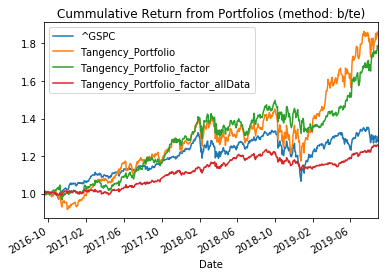

In [10]:
method = 'b/te'
chosenETF = rank_method(method) 


chosenETF_df = allPTF[chosenETF]

ERe,Stde,Cove = chosenETF_df.mean(),chosenETF_df.std(),chosenETF_df.cov()
Weights = pd.DataFrame([],index=chosenETF_df.columns)
Weights['Tangency_Portfolio'] = (np.linalg.inv(Cove) @ ERe.values) / (np.linalg.inv(Cove) @ ERe.values).sum()

print('Current method is: '+ method)
print(Weights.T)

MKT_RET = pd.DataFrame((allPTF['^GSPC']+1).cumprod())
PTF_RET = (chosenETF_df @ Weights + 1).cumprod()
chosenfactor = ['MKTRF','SMB','MOM']
chosenfactor_df = factor_d[chosenfactor]
chosenfactor_df = chosenfactor_df.tail(PTF_RET.shape[0])
ERe_f,Stde_f,Cove_f = chosenfactor_df.mean(),chosenfactor_df.std(),chosenfactor_df.cov()
Weights_f = pd.DataFrame([],index=chosenfactor_df.columns)
Weights_f['Tangency_Portfolio_factor'] = (np.linalg.inv(Cove_f) @ ERe_f.values) / (np.linalg.inv(Cove_f) @ ERe_f.values).sum()
print(Weights_f.T)

FACTOR_RET_2017 = (chosenfactor_df @ Weights_f[['Tangency_Portfolio_factor']]+ 1).cumprod()

chosenfactor_df2 = factor_d[chosenfactor]
ERe_f2,Stde_f2,Cove_f2 = chosenfactor_df2.mean(),chosenfactor_df2.std(),chosenfactor_df2.cov()
Weights_f2 = pd.DataFrame([],index=chosenfactor_df.columns)
Weights_f2['Tangency_Portfolio_factor_allData'] = (np.linalg.inv(Cove_f2) @ ERe_f2.values) / (np.linalg.inv(Cove_f2) @ ERe_f2.values).sum()
FACTOR_RET_All = (chosenfactor_df @ Weights_f2[['Tangency_Portfolio_factor_allData']]+ 1).cumprod()
allRET = pd.merge(pd.merge(MKT_RET,PTF_RET,left_index = True,right_index = True),FACTOR_RET_2017,left_index = True,right_index = True)
allRET = pd.merge(allRET,FACTOR_RET_All,left_index = True,right_index = True)

print(Weights_f2.T)

allRET.plot()
plt.title('Cummulative Return from Portfolios'+' (method: ' + method + ')')

MKT_RET_NC = pd.DataFrame((allPTF['^GSPC']))
PTF_RET_NC = (chosenETF_df @ Weights)
FACTOR_RET_2017_NC = (chosenfactor_df @ Weights_f[['Tangency_Portfolio_factor']])
FACTOR_RET_All_NC = (chosenfactor_df @ Weights_f2[['Tangency_Portfolio_factor_allData']])
allRET_NC = pd.merge(pd.merge(MKT_RET_NC,PTF_RET_NC,left_index = True,right_index = True),FACTOR_RET_2017_NC,left_index = True,right_index = True)
allRET_NC = pd.merge(allRET_NC,FACTOR_RET_All_NC,left_index = True,right_index = True) 
WeightsTracking = Weights.copy().T.rename(columns = {Weights.index[0]:'MKTRF',Weights.index[1]:'SMB',Weights.index[2]:'MOM'}).T
te = (chosenETF_df @ Weights - chosenfactor_df @ WeightsTracking).std()

print('Mean:')
print(allRET_NC.mean()*252)
print('Std:')
print(allRET_NC.std()*252**0.5)
print('SR:')
print(allRET_NC.mean()*252/(allRET_NC.std()*252**0.5))
print('The tracking error of the tangency portfolio over the three factors is:' + str(te))

Tangency Portfolio: represents the portfolio we constructed using the ETFs we chose on a previous step.  
Tangency Portfolio_factor: represents the factor portfolio data from the same time period as the ETFs (744 observations)  
Tangency Portfolio_factor_allData: represents the factor portfolio, if we could construct it using all the historic data available on the factors. (25559 observations)  

The ETFs portfolio optimazation outweights the Market ETF, shorts the Small Minus Big ETF and places 0.6 on the Momentum ETF. Although the Market ETF has a marginally lower Sharpe ratio than the Momentum ETF is not clear why the optimization tool outweigh the Market.

The Tangency Portfolio_factor assigns the most weight on the Momentum ETF, a smaller percentage on the Market but it also shorts SMB. This could be an indication of the tracking ability of the Momentum ETFs which we will examine later. Also, by investing in the factors directly we circumvent any inefficiencies/fees/tracking errors of the ETFs.

The Tangency Portfolio_factor_allData on the other hand does not short the SMB but still assigns the biggest weight on Momentum. The difference we observe in the SMB factor in this case may arise from the change in the factor returns over time. 

It is obvious that our portfolio achieves a higher return compared to the market and the Tangency Portfolio_factor. However this return comes with the expense of volatility. Evidently the sharpe ratio of our portfolio is lower than the Tangency Portfolio_factor. 

Staying true to our investor profile even though we see the above result within our investment thesis.
Certainly if we could invest directly into the factors we would achieve a higher sharpe ratio, which is more desirable and less expensive.

Overall our Tangency Portfolio has achieved its goal of utilizing the factor ETFs to provide exposure to set factors and achieve adequate returns.


In [11]:
def oneTypeRegression(fundType,factor_d):
    ETF = mergePTF(fundType+"/",factor_d)
    print('# of entries: '+str(ETF.shape[0]))
    RESULTS = Time_Series_Regressions_chosenFactor(ETF, factor_d, [fundType], ETF.columns)[0]
    return RESULTS[RESULTS.index.str.contains(fundType)].sort_values('tracking_error',ascending = True)

Based on the interesting results we observed on the previous matter, we thought it would be useful to compare the results of the initial one factor regressions, which were run based on the minimum number of common observations (744), to the one factor regressions if each factor was regressed without the above restriction.

In [12]:
oneTypeRegression('MOM',factor_d)

# of entries: 744


,AvgReturns,Std,alpha,t_alpha,tracking_error,b_distance_to_1,b/te,b_MOM,t_MOM,R-Squared,SR,AR,IR
FDMO_MOM,0.124675,0.140670,0.085593,1.086303,0.009319,0.604984,42.389868,0.395016,7.954278,0.078571,0.886288,0.632215,9.185118
PDP_MOM,0.131561,0.144122,0.089236,1.110989,0.009389,0.572202,45.564018,0.427798,8.450452,0.087791,0.912843,0.646582,9.504385
MTUM_MOM,0.166465,0.152570,0.115330,1.376544,0.009545,0.483159,54.146506,0.516841,9.787584,0.114344,1.091075,0.801132,12.082517
SPMO_MOM,0.153563,0.157225,0.116406,1.306500,0.010391,0.624437,36.141654,0.375563,6.687928,0.056854,0.976705,0.760367,11.202069
DWTR_MOM,0.103455,0.178233,0.046946,0.476427,0.010974,0.428843,52.045526,0.571157,9.196603,0.102323,0.580445,0.277275,4.277845
XMMO_MOM,0.216247,0.175312,0.174386,1.756433,0.011325,0.576884,37.360888,0.423116,6.761649,0.058041,1.233503,1.022223,15.398149
XSMO_MOM,0.133578,0.176637,0.113443,1.107987,0.012136,0.796486,16.769809,0.203514,3.153737,0.013227,0.756229,0.644835,9.347804
DWAS_MOM,0.123759,0.193232,0.085238,0.771734,0.012527,0.610643,31.081227,0.389357,5.593161,0.040455,0.640472,0.449140,6.804259
PTF_MOM,0.241608,0.237374,0.149231,1.171471,0.013770,0.066305,67.805063,0.933695,11.629184,0.154163,1.017839,0.681782,10.837188
PTH_MOM,0.197618,0.246133,0.141523,1.012513,0.015338,0.433023,36.964986,0.566977,6.435912,0.052872,0.802891,0.589270,9.226850


It is clear that the restricting factor on the previous regressions was Momentum. ETFs tracking momentum are fairly new and this is obvious from the higher tracking errors compared to the rest of the factors and R**2. Maybe after more observations are taken into account the ETF managers will improve their ability to recreate a momentum strategy.
An interesting note from before was that Momentum factor had a weight of 0.9 in the scenario where we could invest in the factors directly. This is indicative of why it has become popular recently.

In [13]:
oneTypeRegression('MKTRF',factor_d)

# of entries: 811


,AvgReturns,Std,alpha,t_alpha,tracking_error,b_distance_to_1,b/te,b_MKTRF,t_MKTRF,R-Squared,SR,AR,IR
VTI_MKTRF,0.115828,0.128760,-0.001353,-0.296053,0.000579,0.031536,1672.006911,0.968464,446.745566,0.995963,0.899570,-0.165029,-2.336224
SPY_MKTRF,0.117609,0.128687,0.000895,0.119464,0.000895,0.035404,1077.535850,0.964596,271.460615,0.989141,0.913912,0.066593,0.999837
VOO_MKTRF,0.118388,0.128337,0.001994,0.266405,0.000902,0.038046,1066.387928,0.961954,270.928609,0.989099,0.922478,0.148502,2.210902
IVV_MKTRF,0.118270,0.128604,0.001646,0.217549,0.000905,0.036138,1065.119199,0.963862,268.642836,0.988914,0.919650,0.121268,1.818639
VONE_MKTRF,0.116698,0.127471,0.001133,0.147486,0.000944,0.044896,1011.452253,0.955104,262.087128,0.988359,0.915489,0.082213,1.200096
OEF_MKTRF,0.118229,0.131495,0.000196,0.015118,0.001475,0.024496,661.160390,0.975504,158.720658,0.968886,0.899113,0.008427,0.132781
DIA_MKTRF,0.139156,0.130969,0.025520,1.133213,0.002591,0.060840,362.518402,0.939160,87.928361,0.905274,1.062516,0.631686,9.850973
IWM_MKTRF,0.090426,0.159573,-0.040936,-1.067241,0.004385,0.085660,247.566832,1.085660,59.679075,0.814899,0.566677,-0.594911,-9.334678
QQQ_MKTRF,0.179403,0.171295,0.034987,0.959189,0.004426,0.193551,269.697112,1.193551,68.993068,0.854733,1.047338,0.534680,7.905726
SPDN_MKTRF,-0.119604,0.129562,-0.003165,-0.257810,0.016488,1.962333,-58.366547,-0.962333,-165.298033,0.971243,-0.923140,-0.143711,-0.191938


Market ETF seem to be doing a better job at tracking the S&P500. Based on the Market Efficiency Hypothesis, this would be the optimal strategy and nothing would be able to surpass it in the long-run. The clear ability of the ETF to track the market factor this could be a sign why our Tangency Portfolio overweighed it. 

In [14]:
oneTypeRegression('SMB',factor_d)

# of entries: 1604


,AvgReturns,Std,alpha,t_alpha,tracking_error,b_distance_to_1,b/te,b_SMB,t_SMB,R-Squared,SR,AR,IR
VIOO_SMB,0.112393,0.157083,0.128062,2.461133,0.008292,0.082901,130.590809,1.082901,26.334170,0.302109,0.715500,0.975513,15.443471
SLY_SMB,0.112644,0.158021,0.128499,2.461147,0.008324,0.095749,131.638315,1.095749,26.556136,0.305660,0.712843,0.975519,15.437315
IJR_SMB,0.113124,0.158258,0.129013,2.468002,0.008335,0.098118,131.751629,1.098118,26.581355,0.306063,0.714805,0.978236,15.478937
SCHA_SMB,0.101778,0.153683,0.115855,2.202303,0.008371,0.027109,116.217268,0.972891,23.401494,0.254755,0.662257,0.872922,13.839519
VB_SMB,0.106519,0.148714,0.118863,2.266692,0.008377,0.146935,101.830830,0.853065,20.584769,0.209175,0.716270,0.898443,14.188698
IJH_SMB,0.101782,0.141674,0.111289,2.132183,0.008482,0.342969,77.464400,0.657031,15.928491,0.136722,0.718424,0.845128,13.121057
IWO_SMB,0.118414,0.177327,0.136615,2.355941,0.009318,0.257862,134.994076,1.257862,27.448340,0.319864,0.667775,0.933818,14.661546
PSEC_SMB,0.059248,0.207674,0.065990,0.814512,0.013151,0.534061,35.429919,0.465939,7.277192,0.031999,0.285295,0.322846,5.017885
SIZE_SMB,0.126578,0.227006,0.129125,1.437279,0.014871,0.823996,11.835285,0.176004,2.478972,0.003821,0.557597,0.569691,8.682902
SPSM_SMB,4.123358,10.229364,4.142363,1.021316,0.644567,0.313409,2.037662,1.313409,0.409759,0.000105,0.403090,0.404817,6.426584


SMB seems to be a tricky factor to track as well. This factor became prominent through the Fama and French 3 factor model more than two decades ago, however the explanatory power of the factor to the ETF does not seem to be high. These regressions could a testiment to the difficulty of implementing a size strategy. 